In [3]:
library('tidyquant', quietly = TRUE)
DATA_FOLDER <- '~/Resilio Sync/FXBootcamp/'
source(paste0(DATA_FOLDER,'/Code/tools/r-tools/data-utils.R'))

ASSET_LIST <- "AssetsDWX-FX-USD"
asset_list <- get_asset_list(ASSET_LIST)

In [5]:
# get_daily_OHLC_ticker <- function(ticker) {
#     #initialize empty data structure
#   td <- data.frame(matrix(ncol=7, nrow=0))
    
#   try(td <- cbind(Ticker = ticker, read.csv(file.path(DATA_FOLDER, 'daily', paste0(ticker,'.csv')), header = FALSE, stringsAsFactors = FALSE)))
#   colnames(td) <- c('Ticker', 'Date', 'Open' ,'High', 'Low', 'Close', 'Volume')
#   td$Date <- as.Date(as.character(td$Date), '%Y%m%d')
#   td$Ticker <- as.character(td$Ticker)
#   return(td)
# }

[1] "AUD/USD" "EUR/USD" "GBP/USD" "NZD/USD" "USD/CAD" "USD/CHF" "USD/JPY"
 [8] "USD/MXN" "USD/NOK" "USD/SEK" "USD/SGD" "USD/TRY"

In [10]:
raw_prices_df <- get_daily_OHLC(asset_list$Name)

In [11]:
head(raw_prices_df)

Ticker,Date,Open,High,Low,Close,Volume
AUDUSD,1999-01-01,0.6107,0.6158,0.6098,0.6125,0
AUDUSD,1999-01-04,0.6135,0.6226,0.6135,0.6220,0
AUDUSD,1999-01-05,0.6122,0.6229,0.6115,0.6220,0
AUDUSD,1999-01-06,0.6220,0.6255,0.6209,0.6215,0
AUDUSD,1999-01-07,0.6215,0.6305,0.6192,0.6287,0
AUDUSD,1999-01-08,0.6287,0.6384,0.6275,0.6346,0


In [14]:
#exchange_rates
usd_prices_df <- convert_common_quote_currency(raw_prices_df, quote_currency = 'USD')
assetNames <- distinct(usd_prices_df, Ticker) 

In [15]:
# Get short term interest rates
currencies <- get_unique_currencies(usd_prices_df)
policy_rates_df <- get_policy_rates(currencies)
usd_extended_prices_df <- append_interest_rate_differential(usd_prices_df, policy_rates_df)


In [16]:
usd_returns <-  usd_extended_prices_df %>%
    group_by(Ticker) %>%
    tq_transmute_(select = "Total_Return_Index", 'ROC', n = 1, type = 'discrete', na.pad = FALSE, col_rename = 'returns')

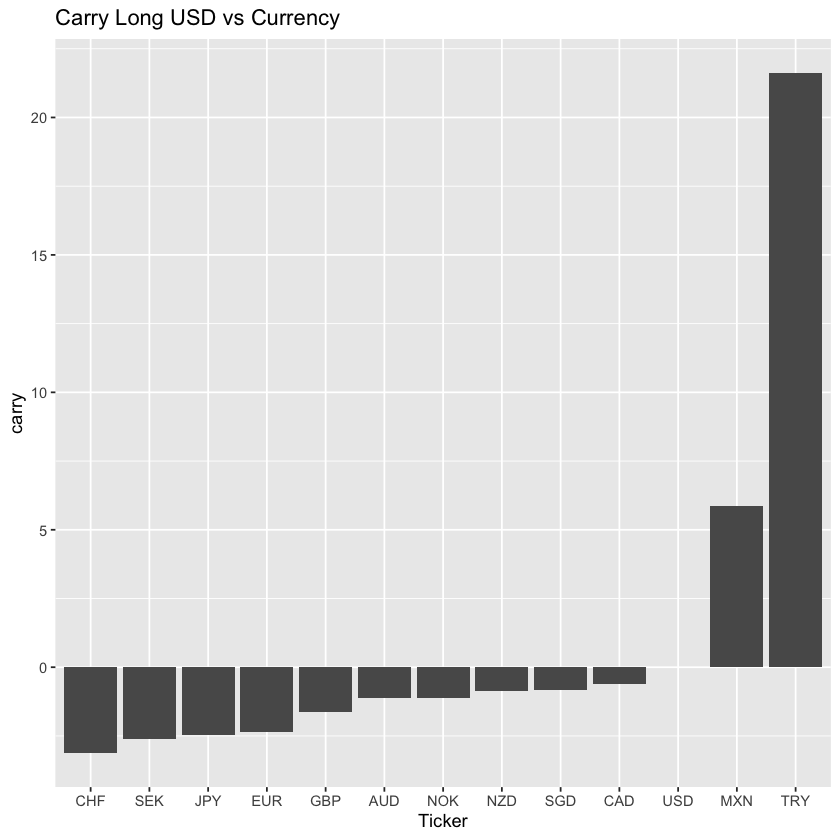

In [23]:
latest_date <- as.Date('2019-07-01')

recent_rates <- policy_rates_df %>%
  filter(Date == latest_date) %>%
  select(Currency, Rate) %>%
  arrange(Rate)

usd_rate <- recent_rates %>% 
  filter(Currency == 'USD') %>%
  select(Rate)

recent_rates$carry <- recent_rates$Rate - usd_rate[[1]]

p <- ggplot(recent_rates, aes(x=reorder(Currency, carry, sum), y=carry)) +
  geom_bar(stat = 'identity') +
  labs(title = 'Carry Long USD vs Currency', x = 'Ticker')

p

### Correlation of Daily returns Since 2016

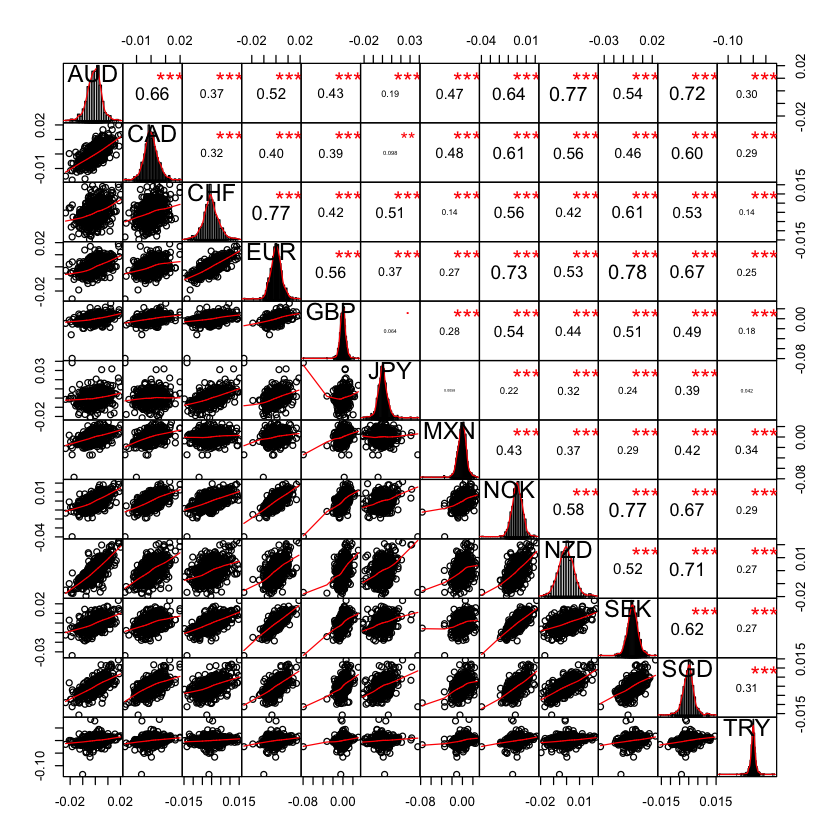

In [24]:
plot_corr_matrix <- function(returns_df, startDate = '2016-01-01', endDate = '2019-12-31') {
  corr_data <- returns_df %>%
    filter(Date >= as.Date(startDate) & Date <= as.Date(endDate)) %>%
    spread(key = Ticker, value = returns) %>%
    na.omit() 
  
  x <- as.matrix.data.frame(corr_data[,-1])
  # Take USD out of column names to make plots nicer
  colnames(x) <- substr(colnames(x),1,3)
  
  correlation <- cor(x, method = 'pearson')
  PerformanceAnalytics::chart.Correlation(x)
}

plot_corr_matrix(usd_returns)

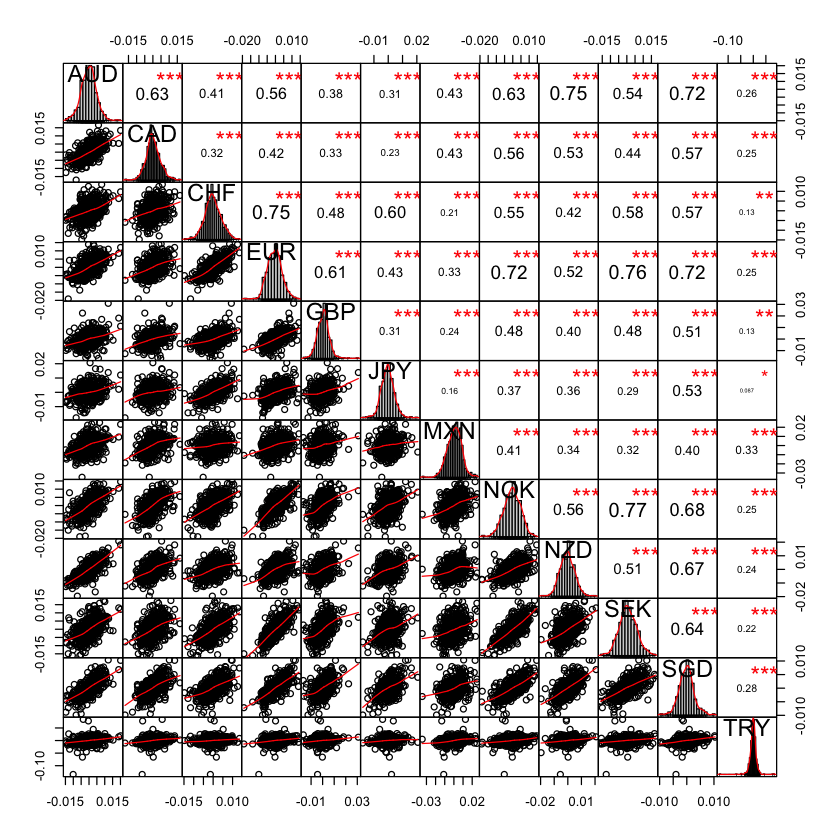

In [25]:
plot_corr_matrix(usd_returns, startDate = '2017-01-01', endDate = '2019-01-01')

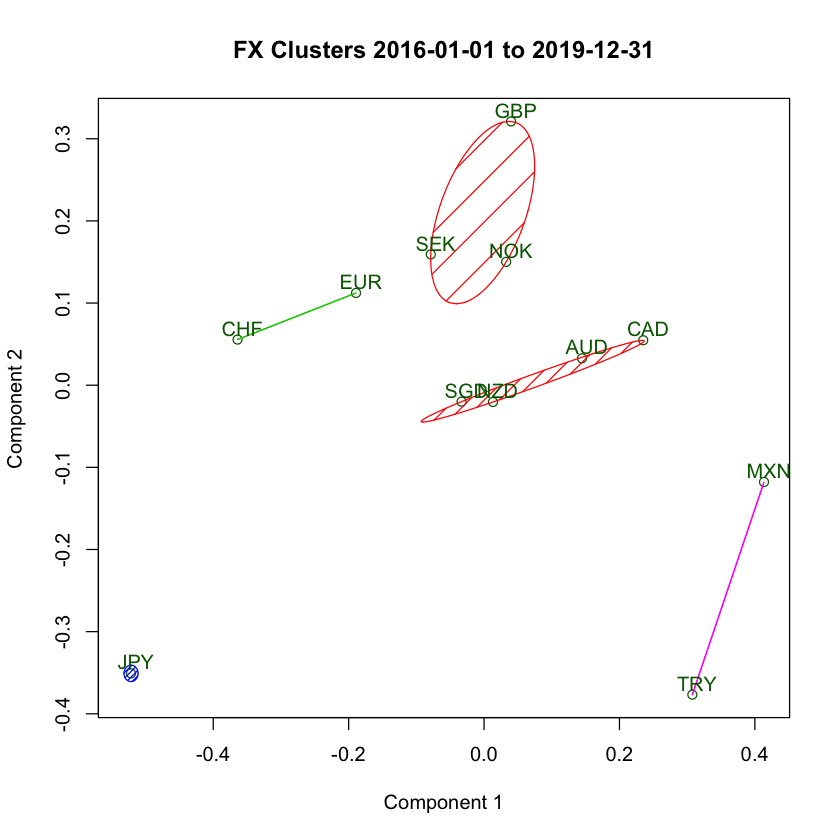

In [29]:
# Based on: https://systematicinvestor.wordpress.com/2013/01/12/examples-of-current-major-market-clusters/
library(cluster)
plot_cor_clusters <- function(returns_df, number_of_clusters = 4, startDate = '2016-01-01', endDate = '2019-12-31') {
  corr_data <- returns_df %>%
  filter(Date >= as.Date(startDate) & Date <= as.Date(endDate)) %>%
  spread(key = Ticker, value = returns) %>%
  na.omit()

  x <- as.matrix.data.frame(corr_data[,-1])
  # Take USD out of column names to make plots nicer
  colnames(x) <- substr(colnames(x),1,3)
  
  correlation <- cor(x, method = 'pearson')
  dissimilarity <- 1 - correlation
  distance <- as.dist(dissimilarity)
  xy <- cmdscale(distance)
  fit <- kmeans(xy, number_of_clusters, iter.max=100, nstart=100)
  clusplot(xy, fit$cluster, color=TRUE, shade=TRUE, labels=3, lines=0, plotchar=F, 
    main = paste('FX Clusters', startDate, 'to', endDate), sub='') 
}

plot_cor_clusters(usd_returns, number_of_clusters = 5)

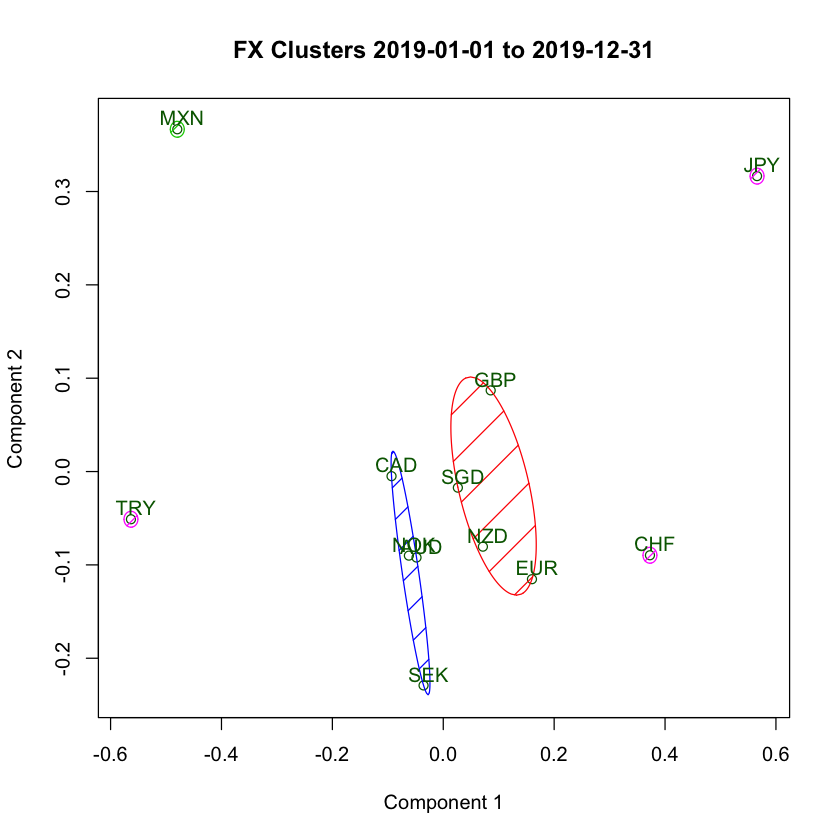

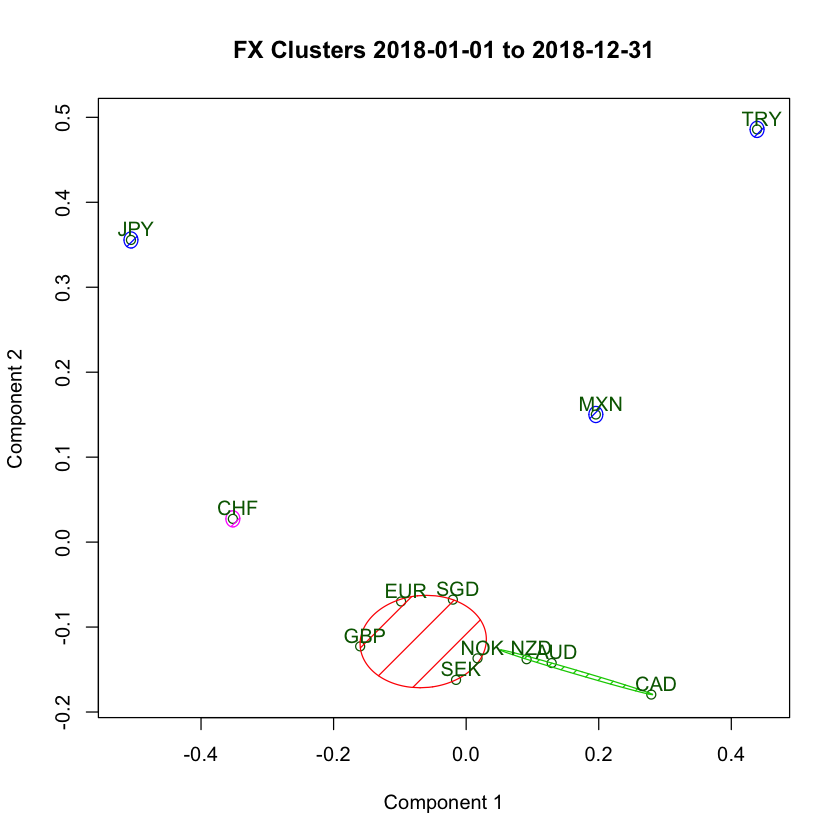

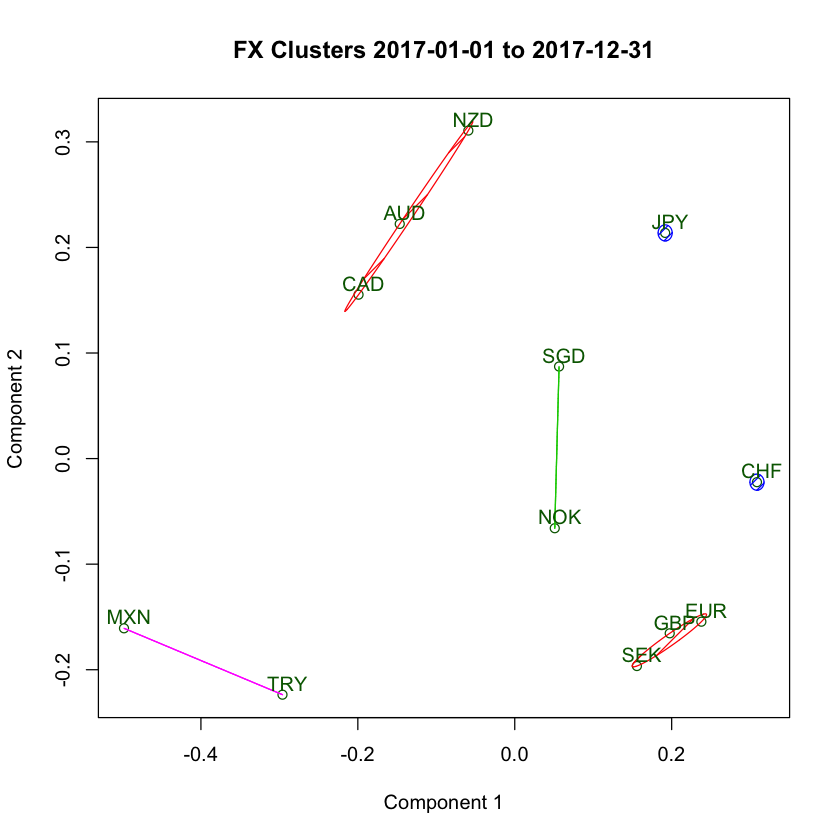

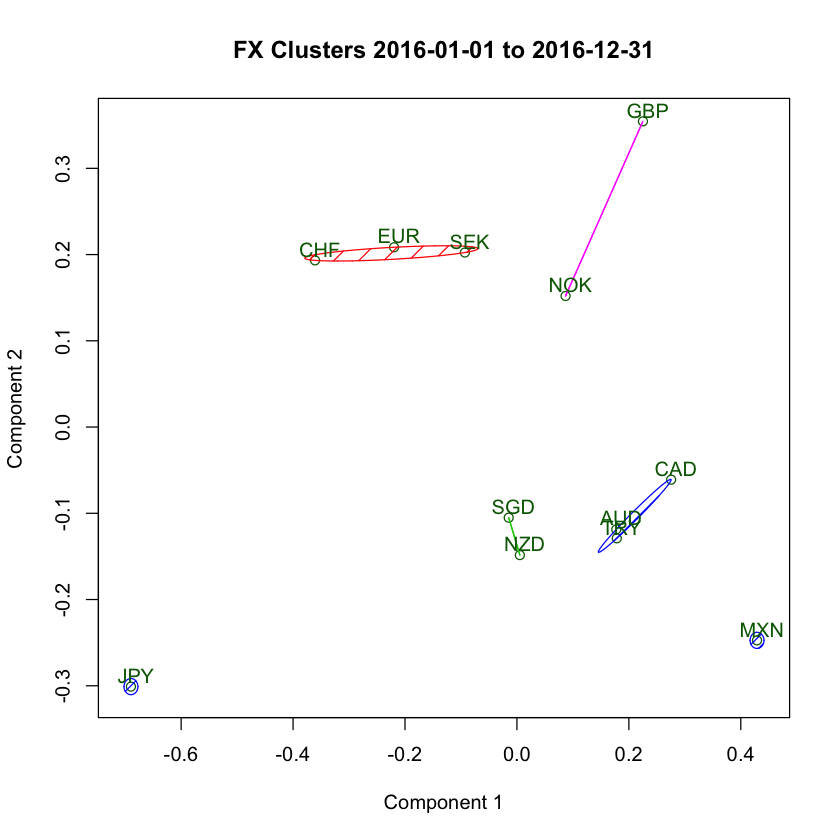

In [30]:
plot_cor_clusters(usd_returns, number_of_clusters = 6, startDate = '2019-01-01', endDate = '2019-12-31')
plot_cor_clusters(usd_returns, number_of_clusters = 6, startDate = '2018-01-01', endDate = '2018-12-31')
plot_cor_clusters(usd_returns, number_of_clusters = 6, startDate = '2017-01-01', endDate = '2017-12-31')
plot_cor_clusters(usd_returns, number_of_clusters = 6, startDate = '2016-01-01', endDate = '2016-12-31')

Does the USD currently has a positive or negative carry against most foreign currencies? What might be the impact of this?

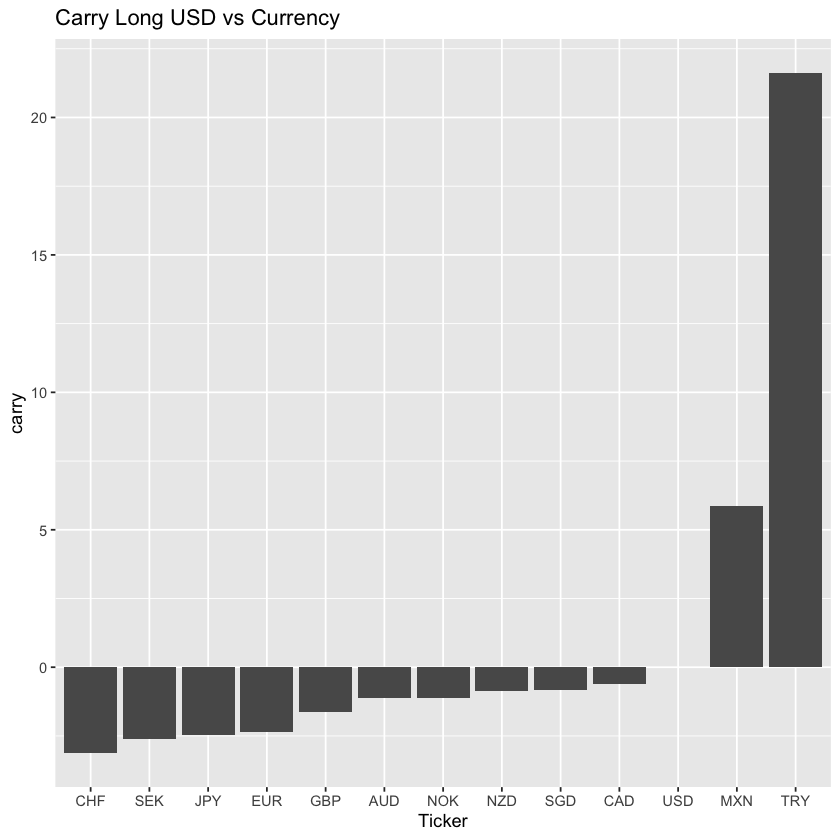

In [31]:
latest_date <- as.Date('2019-07-01')

recent_rates <- policy_rates_df %>%
  filter(Date == latest_date) %>%
  select(Currency, Rate) %>%
  arrange(Rate)

usd_rate <- recent_rates %>% 
  filter(Currency == 'USD') %>%
  select(Rate)

recent_rates$carry <- recent_rates$Rate - usd_rate[[1]]

p <- ggplot(recent_rates, aes(x=reorder(Currency, carry, sum), y=carry)) +
  geom_bar(stat = 'identity') +
  labs(title = 'Carry Long USD vs Currency', x = 'Ticker')

p

The USD currently has positive carray vs most developed market currencies. Assuming we could cover the brokerage fees, for currency pairs where the base currency is USD we could go long (USDJPY). For currency pairs where the USD is not the base, but instead the quoted, we could go short (EURUSD). 

Experiment with the subsetting return data and investigating changing correlation structures. What relationships seem relatively stable? What seems more dynamic?

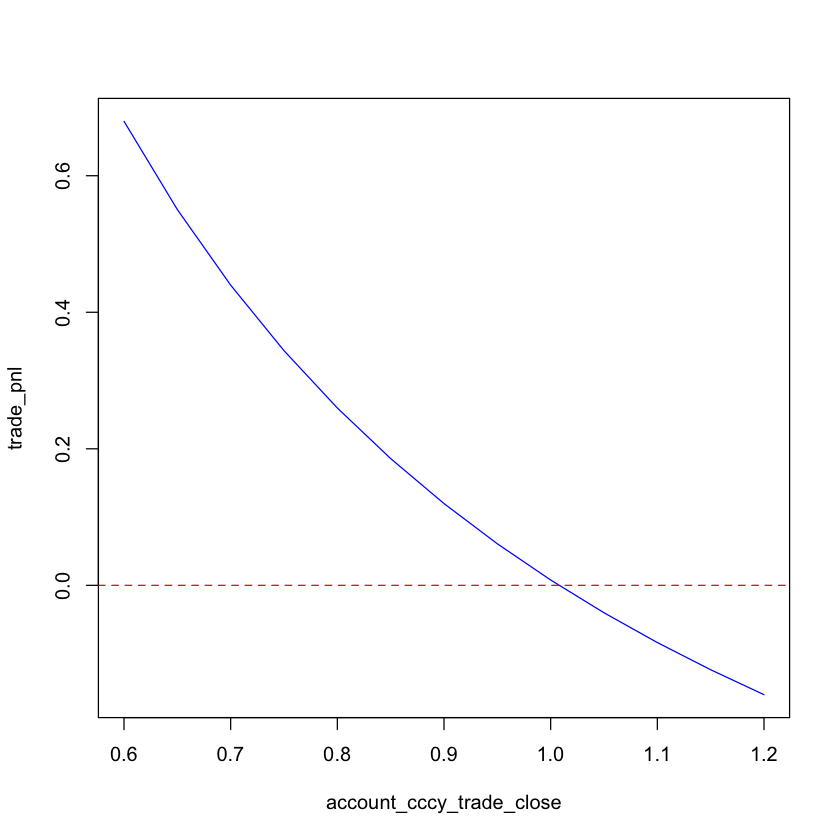

In [32]:
fx_pnl <- function(base.quote.buy, base.quote.sell, acnt.quote.buy, acnt.quote.sell) {
  
  return((base.quote.sell/acnt.quote.sell) / (base.quote.buy/acnt.quote.buy) - 1)
}

account_cccy_trade_close <- seq(0.6, 1.2, 0.05)
trade_pnl <- fx_pnl(base.quote.buy=1.05, base.quote.sell=1.43, acnt.quote.buy=0.74, acnt.quote.sell=account_cccy_trade_close)

plot(account_cccy_trade_close, trade_pnl, type='l', col='blue')
abline(h=0.0, col='red', lty=2)